In [1]:
pip install wfdb

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb
from scipy.ndimage import gaussian_filter1d
from scipy.signal import medfilt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix, classification_report)
from sklearn.ensemble import RandomForestClassifier

In [3]:
data_list=[] #takes all the subjects 
directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
csv_path = os.path.join(directory, 'subjectinfo.csv') 
for i in range(1,21):
    ACCTEMPEDA_Path = os.path.join(directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file

    # ACCTEMPEDA_DownSampled = downsample_by_averaging(ACCTEMPEDA_Record.p_signal, 8) # downsample ACCTEMP EDA as it is 8 HZ
    # ACCTEMPEDA_DownSampled_Record = wfdb.Record(
    #     record_name=f'Subject{i}_AccTempEDA_DownSampled', 
    #     p_signal=ACCTEMPEDA_DownSampled, 
    #     fs=1,
    #     sig_name=ACCTEMPEDA_Record.sig_name,
    #     units=ACCTEMPEDA_Record.units        
    # )
    with open(csv_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if int(row['subject']) == i:
                data_list.append({
                    'subject_id': i,
                    'acc_temp_eda': ACCTEMPEDA_Record,
                    'spo2_hr': SPO2HR_Record,
                    'annotations': annotations,
                    'age': int(row['age']),
                    'gender': row['gender'],
                    'height_cm': int(row['height/cm']),
                    'weight_kg': int(row['weight/kg'])
                })
                #print(f"Subject {i} Metadata:")
                #print(f"  Age: {int(row['age'])}")
                #print(f"  Gender: {row['gender']}")
                #print(f"  Height (cm): {int(row['height/cm'])}")
                #print(f"  Weight (kg): {int(row['weight/kg'])}")
                

In [4]:
sub = data_list[1]
#print()
print(sub['acc_temp_eda'].p_signal)

[[ 0.96997131 -0.67005829 -0.07004547 28.70009461  0.81804387]
 [ 0.96997131 -0.6800177  -0.07004547 28.90009461  0.81804387]
 [ 0.97998291 -0.67005829 -0.07004547 28.90009461  0.81601674]
 ...
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.02999969 -0.55000336 -0.21004151 32.9         0.64901976]
 [ 1.0199881  -0.55000336 -0.21004151 32.9         0.64901976]]


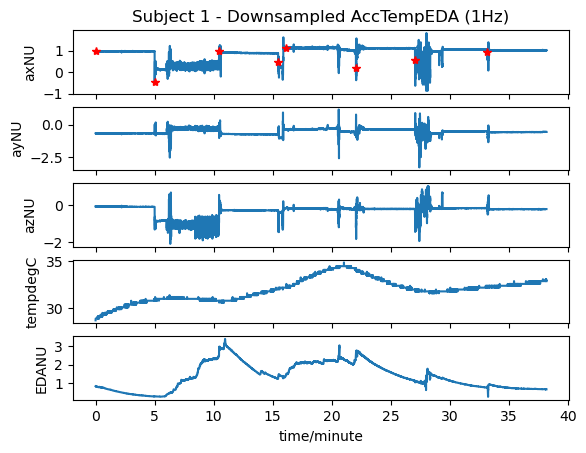

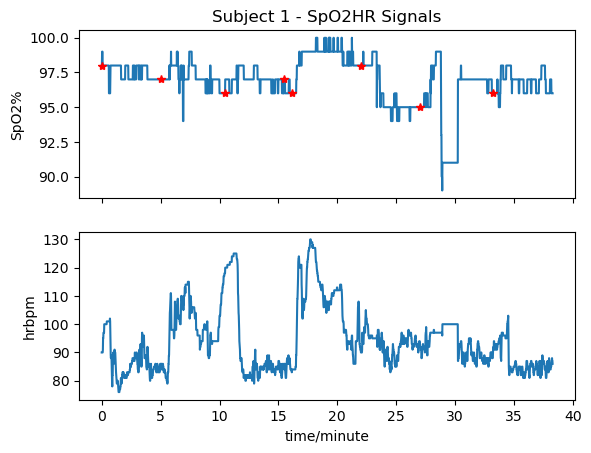

In [5]:
subject = data_list[1]  
wfdb.plot_wfdb( record=subject['acc_temp_eda'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - Downsampled AccTempEDA (1Hz)')
wfdb.plot_wfdb( record=subject['spo2_hr'], annotation=subject['annotations'], time_units='minutes', title='Subject 1 - SpO2HR Signals')

# Extracting and Combining Data by Class

## Utility functions

In [6]:
# extract the ranges of each stage from their annotation
def get_stages(annotation, size):
    stages = []
    for i, (samp, note) in enumerate(zip(annotation.sample, annotation.aux_note)):
        stages.append({"Label" : note, "start": samp, "end": 0}) # dummy end
    
    for i in range((len(stages) - 1)):
        stages[i]["end"] = stages[i+1]["start"] # each stages end is the next one's beginning
    stages[-1]["end"] = size # set the end of last stage as the length of the data

    return stages  

In [7]:
# find label of a data point at a given index based on the ranges of each stage
def find_label(stages, index):
    for stage in stages:
        if index >= stage['start'] and index < stage['end']:
            return stage["Label"]
    return "Unknown"

In [8]:
# label the AccTempEDA data
def extract_labeled_AccTempEDA(record, annotation):
    stages = get_stages(annotation, record.p_signal.shape[0]) # get the range for each stage
    data = record.p_signal # extract the data into a numpy array
    labels = [] # array to store the labels corresponding to each data point in the record
    for idx, entry in enumerate(data): # loop over all the data
        labels.append((find_label(stages, idx))) # find the label based on the points index
    labeled_data = np.column_stack((data, labels)) # append the labels column to the data 
    return labeled_data # return the labeled data

In [9]:
# downsample by averaging BUT make sure you stay within a given class
def downsample_by_averaging(data, factor):
    downsampled_data = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, :-1].astype(float) # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            avg_chunk = np.mean(chunk, axis=0)
            downsampled_data.append(np.append(avg_chunk, class_label))  # avg of each column while adding back the label
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
                    
    return np.array(downsampled_data)

In [10]:
# combine AccTempEDA and Spo2HR data while truncating them to be of the same length
# CRUCIAL but naive assumption! time stamps match after downsampling (technically incorrect)
def combine(AccTempEDA, Spo2HR):
    min_length = min(len(AccTempEDA), len(Spo2HR)) # finds the minimum length to align the points properly

    # concatenate the truncated columns from AccTempEDA with those from Spo2HR and add the labels at the end
    combined_data = np.column_stack((AccTempEDA[:min_length, :-1], Spo2HR[:min_length], AccTempEDA[:min_length, -1:]))

    return combined_data

In [11]:
def balance_classes(combined_data):
    balanced_data = []
    relaxed = False
    for data in combined_data:
        if data[-1] != "Relax": # we've passed the first relax
            relaxed = True
            balanced_data.append(data)
        elif not relaxed:
            balanced_data.append(data)
    return np.array(balanced_data)

# Extracting Raw and Preprocessed data

In [12]:
# val is 1 incase labels are included 0 otherwise 
def preprocess(wavevec):
    final_vec = [] # stores the filtered signals
    for i in range(0,len(wavevec[0])): # goes through each point in the signal
        one_col = [wavevec[s][i].astype(float) for s in range(0,len(wavevec))] # filters column by column
        one_col = medfilt(one_col, kernel_size=9) # filtering each column
        if i == 0:
            final_vec = one_col
        else:
            final_vec = np.column_stack((final_vec, one_col))
    return final_vec

In [13]:
# get the full data for each subject
def get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [14]:
def get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    #print(len(combined_data))
    return combined_data # return the resulting data

In [15]:
def get_subject_data_raw_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    #print(AccTempEDA)
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = Spo2HR_record.p_signal # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    balanced_data = balance_classes(combined_data)
    return balanced_data # return the resulting data

In [16]:
def get_subject_data_preprocessed_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation):
    AccTempEDA_record.p_signal = preprocess(AccTempEDA_record.p_signal)
    AccTempEDA = extract_labeled_AccTempEDA(AccTempEDA_record, AccTempEDA_annotation) # extract and label AccTempEDA record
    #print(AccTempEDA[3000])
    AccTempEDA = downsample_by_averaging(AccTempEDA, 8) # downsample to match the other Spo2HR's rate
    Spo2HR = preprocess(Spo2HR_record.p_signal) # extract Spo2HR record
    #print(Spo2HR.shape)
    combined_data = combine(AccTempEDA, Spo2HR) # combine both records
    balanced_data = balance_classes(combined_data)
    return balanced_data # return the resulting data

# Function to read and get raw data for all subjects and store them in csvs

In [17]:
read_directory="non-eeg-dataset-for-assessment-of-neurological-status-1.0.0" # directory to all the files ATR, DAT, HEA
type = "Preprocessed"
write_directory= f"Subject Data {type}"
all_sub_info = []
for i in range(1,21):
    csv_path = os.path.join(write_directory, f'subject_{i}_data_{type}.csv')
    ACCTEMPEDA_Path = os.path.join(read_directory, f'Subject{i}_AccTempEDA') 
    SPO2HR_Path = os.path.join(read_directory, f'Subject{i}_SpO2HR') 

    ACCTEMPEDA_Record = wfdb.rdrecord(ACCTEMPEDA_Path) #  rdrecord read .dat and .hea file
    SPO2HR_Record = wfdb.rdrecord(SPO2HR_Path) 
    annotations = wfdb.rdann(ACCTEMPEDA_Path, 'atr') # rdann reads .atr file
    subject_data = get_subject_data_preprocessed(ACCTEMPEDA_Record, SPO2HR_Record, annotations)
    all_sub_info.append(subject_data)
    # #print(f'subject{i}: {len(subject_data)}') 
    # with open(csv_path, mode='w', newline='') as csvfile:
    #     writer = csv.writer(csvfile)
    #     # Write headers
    #     writer.writerow(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'HR', 'label'])
    #     # Write each row of subject data
    #     for row in subject_data:
    #         writer.writerow(row)

In [18]:
len(all_sub_info)

20

# Function to get the data in the desired window sizes

In [19]:
def window_data(data, factor):
    windowed_data = []
    labels = []
    i = 0
    while i + factor <= len(data): # cannot use for (range) as we may need to update i
        class_label = data[i][-1] # get the expected class lavel
        if class_label == data[i + factor - 1][-1]: # if all the data belongs to one class
            chunk = data[i: i + factor, : -1] # extract a chunk (ignore last column [label] to average and cast to float to counter the upcasting when we added the label)
            windowed_data.append(chunk)  # avg of each column while adding back the label
            labels.append(class_label)
            i += factor
        else: # we have crossed into a new class, need to reset i to beginning of the new class
            for j in range(i + 1, i + factor):
                if data[j-1][-1] != data[j][-1]: # if data at index j has a different class from the one before it, update i and break
                    i = j
                    break
    # flatten the windows

    windowed_data = [window.flatten() for window in windowed_data]
                    
    return np.array(windowed_data).astype(float), np.array(labels)

# Compute Z score [Normalization] (importnat for methods like KNN, logistic regression, SVM and neural networks

In [20]:
def normalize_data(train_data, test_data):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_data)
    X_test_scaled = scaler.transform(test_data)
    return X_train_scaled, X_test_scaled
    

# Getting Data Raw, Preprocessed (Balanced and Unbalanced)

In [21]:
data_dir = r"non-eeg-dataset-for-assessment-of-neurological-status-1.0.0"
all_preprocessed_data_balanced=[]
all_preprocessed_data=[]
all_raw_data_balanced=[]
all_raw_data=[]
for i in range(1, 21):
    AccTempEDA_record = wfdb.rdrecord(fr"{data_dir}\Subject{i}_AccTempEDA")
    Spo2HR_record = wfdb.rdrecord(fr"{data_dir}\Subject{i}_SpO2HR")
    AccTempEDA_annotation = wfdb.rdann(fr"{data_dir}\Subject{i}_AccTempEDA", 'atr')
    
    data = get_subject_data_preprocessed(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
    raw_data = get_subject_data_raw(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
    data_balanced = get_subject_data_preprocessed_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
    raw_data_balanced = get_subject_data_raw_balanced(AccTempEDA_record, Spo2HR_record, AccTempEDA_annotation)
    
    all_preprocessed_data.append(data)
    all_raw_data.append(raw_data)
    all_preprocessed_data_balanced.append(data_balanced)
    all_raw_data_balanced.append(raw_data_balanced)

## Least Squares

In [22]:
def least_squared_all_subs(data, norm=False, window=1):
    precision_list_squares = []
    recall_list_squares = []
    f1_list_squares = []
    accuracy_list_squares = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)
        
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        all_preds = []
        all_true = []
        
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            clf = RidgeClassifier()
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_squares.append(avg_precision)
        recall_list_squares.append(avg_recall)
        f1_list_squares.append(avg_f1_score)
        accuracy_list_squares.append(accuracy)

    overall_avg_precision_squares = sum(precision_list_squares) / len(precision_list_squares)
    overall_avg_recall_squares = sum(recall_list_squares) / len(recall_list_squares)
    overall_avg_f1_squares = sum(f1_list_squares) / len(f1_list_squares)
    overall_avg_accuracy_squares = sum(accuracy_list_squares) / len(accuracy_list_squares)

    print("Overall averages for 20 subjects with Least Squares classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_squares:.3f}")
    print(f"Average Precision: {overall_avg_precision_squares:.3f}")
    print(f"Average Recall: {overall_avg_recall_squares:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_squares:.3f}")


### Least Squares on Raw Data (Unbalanced)

In [23]:
least_squared_all_subs(all_raw_data, norm = False)

Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.865
Average Precision: 0.881
Average Recall: 0.820
Average F1-Score: 0.825


### Least Squares on Raw Data (Balanced)

In [24]:
least_squared_all_subs(all_raw_data_balanced, norm = False)

Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.938
Average Precision: 0.943
Average Recall: 0.942
Average F1-Score: 0.941


### Least Squares on Preprocessed (Unbalanced)

In [25]:
least_squared_all_subs(all_preprocessed_data, norm = True)

Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.866
Average Precision: 0.878
Average Recall: 0.823
Average F1-Score: 0.828


### Least Squares on Preprocessed (Balanced)

In [26]:
least_squared_all_subs(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.945
Average Precision: 0.948
Average Recall: 0.949
Average F1-Score: 0.947


### Windows 1,5,10,15

In [27]:
print("Window 1")
least_squared_all_subs(all_preprocessed_data_balanced, norm=True,window=1)
print("Window 5")
least_squared_all_subs(all_preprocessed_data_balanced, norm=True,window=5)
print("Window 10")
least_squared_all_subs(all_preprocessed_data_balanced, norm=True,window=10)
print("Window 15")
least_squared_all_subs(all_preprocessed_data_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.945
Average Precision: 0.948
Average Recall: 0.949
Average F1-Score: 0.947
Window 5
Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.935
Average Precision: 0.938
Average Recall: 0.940
Average F1-Score: 0.937
Window 10
Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.927
Average Precision: 0.932
Average Recall: 0.934
Average F1-Score: 0.930
Window 15
Overall averages for 20 subjects with Least Squares classifier:
Average Accuracy: 0.920
Average Precision: 0.925
Average Recall: 0.924
Average F1-Score: 0.922


### Least Squares Leave One Subject Out

In [28]:
def least_squared_leave_one_out(data, norm = False, window = 1):
    all_preds = []
    all_true = []
    
    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        if(window == 1):    
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if(norm):
            X_train, X_test = normalize_data(X_train, X_test)
                
        clf = RidgeClassifier(random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)
    
    report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    
    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']
    
    print("Overall averages for 20 subjects with Least Sqaures classifier:")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")

In [29]:
least_squared_leave_one_out(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with Least Sqaures classifier:
Average Precision: 0.866
Average Recall: 0.812
Average F1-Score: 0.816


### KNN

In [30]:
def knn_all_subs(data, norm=False, window=1):
    precision_list_knn = []
    recall_list_knn = []
    f1_list_knn = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)
            
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            knn = KNeighborsClassifier()
            param_grid = {'n_neighbors': range(1, 21)}
            grid_search = GridSearchCV(knn, param_grid, cv=5)
            grid_search.fit(X_train, y_train)

            best_k = grid_search.best_params_['n_neighbors']
            final_knn = KNeighborsClassifier(n_neighbors=best_k)
            final_knn.fit(X_train, y_train)
            y_pred = final_knn.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_knn.append(avg_precision)
        recall_list_knn.append(avg_recall)
        f1_list_knn.append(avg_f1_score)

    overall_avg_precision_knn = sum(precision_list_knn) / len(precision_list_knn)
    overall_avg_recall_knn = sum(recall_list_knn) / len(recall_list_knn)
    overall_avg_f1_knn = sum(f1_list_knn) / len(f1_list_knn)

    print("Overall averages for 20 subjects with KNN classifier:")
    print(f"Average Precision: {overall_avg_precision_knn:.3f}")
    print(f"Average Recall: {overall_avg_recall_knn:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_knn:.3f}")


### KNN on Raw Data (Unbalanced)

In [31]:
knn_all_subs(all_raw_data, norm = False)

Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.939
Average Recall: 0.943
Average F1-Score: 0.941


### KNN on Raw Data (Balanced) 

In [32]:
knn_all_subs(all_raw_data_balanced, norm = False)

Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.981
Average Recall: 0.981
Average F1-Score: 0.981


### KNN on Preprocessed (Unbalanced)

In [33]:
knn_all_subs(all_preprocessed_data, norm = True)

Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.985
Average Recall: 0.984
Average F1-Score: 0.984


### KNN on Preprocessed (Balanced)

In [34]:
knn_all_subs(all_preprocessed_data_balanced, norm = True)

Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.991
Average Recall: 0.991
Average F1-Score: 0.991


### Windows 1,5,10,15

In [35]:
print("Window 1")
knn_all_subs(all_preprocessed_data_balanced, norm=True,window=1)
print("Window 5")
knn_all_subs(all_preprocessed_data_balanced, norm=True,window=5)
print("Window 10")
knn_all_subs(all_preprocessed_data_balanced, norm=True,window=10)
print("Window 15")
knn_all_subs(all_preprocessed_data_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.991
Average Recall: 0.991
Average F1-Score: 0.991
Window 5
Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.978
Average Recall: 0.979
Average F1-Score: 0.978
Window 10
Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.968
Average Recall: 0.969
Average F1-Score: 0.967
Window 15
Overall averages for 20 subjects with KNN classifier:
Average Precision: 0.964
Average Recall: 0.964
Average F1-Score: 0.962


### KNN leave one subject out

In [36]:
def knn_leave_one_out(data, norm=False, window=1, n_neighbors=5):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        knn = KNeighborsClassifier(n_neighbors=n_neighbors)
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print(f"Overall averages for 20 subjects with KNN classifier (k={n_neighbors}):")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [37]:
knn_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with KNN classifier (k=5):
Average Accuracy: 0.588
Average Precision: 0.595
Average Recall: 0.603
Average F1-Score: 0.597


## Fishers Linear Discriminant

In [38]:
def fishers_lda_all_subs(data, norm=False, window=1):
    precision_list_fishers = []
    recall_list_fishers = []
    f1_list_fishers = []
    accuracy_list_fishers = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_fishers.append(avg_precision)
        recall_list_fishers.append(avg_recall)
        f1_list_fishers.append(avg_f1_score)
        accuracy_list_fishers.append(accuracy)

    overall_avg_precision_fishers = sum(precision_list_fishers) / len(precision_list_fishers)
    overall_avg_recall_fishers = sum(recall_list_fishers) / len(recall_list_fishers)
    overall_avg_f1_fishers = sum(f1_list_fishers) / len(f1_list_fishers)
    overall_avg_accuracy_fishers = sum(accuracy_list_fishers) / len(accuracy_list_fishers)

    print("Overall averages for 20 subjects with Fisher's LDA classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_fishers:.3f}")
    print(f"Average Precision: {overall_avg_precision_fishers:.3f}")
    print(f"Average Recall: {overall_avg_recall_fishers:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_fishers:.3f}")


### FLDA on Raw Data (Unbalanced)

In [39]:
fishers_lda_all_subs(all_raw_data,norm = False)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.889
Average Precision: 0.888
Average Recall: 0.868
Average F1-Score: 0.871


### FLDA on Raw Data (Balanced)

In [40]:
fishers_lda_all_subs(all_raw_data_balanced,norm = False)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.963
Average Precision: 0.965
Average Recall: 0.966
Average F1-Score: 0.965


### FLDA on Preproccesed Data (Unbalanced)

In [41]:
fishers_lda_all_subs(all_preprocessed_data,norm = True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.890
Average Precision: 0.889
Average Recall: 0.870
Average F1-Score: 0.872


### FLDA on Preproccesed Data (Balanced)

In [42]:
fishers_lda_all_subs(all_preprocessed_data_balanced,norm = True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.964
Average Precision: 0.966
Average Recall: 0.967
Average F1-Score: 0.966


### Windows 1,5,10,15

In [43]:
print("Window 1")
fishers_lda_all_subs(all_preprocessed_data_balanced, norm=True,window=1)
print("Window 5")
fishers_lda_all_subs(all_preprocessed_data_balanced, norm=True,window=5)
print("Window 10")
fishers_lda_all_subs(all_preprocessed_data_balanced, norm=True,window=10)
print("Window 15")
fishers_lda_all_subs(all_preprocessed_data_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.964
Average Precision: 0.966
Average Recall: 0.967
Average F1-Score: 0.966
Window 5
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.943
Average Precision: 0.946
Average Recall: 0.948
Average F1-Score: 0.945
Window 10
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.862
Average Precision: 0.865
Average Recall: 0.870
Average F1-Score: 0.863
Window 15
Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.846
Average Precision: 0.853
Average Recall: 0.856
Average F1-Score: 0.848


### Fishers Leave One Subject out

In [44]:
def fishers_lda_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        lda = LinearDiscriminantAnalysis()
        lda.fit(X_train, y_train)
        y_pred = lda.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Fisher's LDA classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [45]:
fishers_lda_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Fisher's LDA classifier:
Average Accuracy: 0.699
Average Precision: 0.707
Average Recall: 0.708
Average F1-Score: 0.707


## Naive Bayes

In [46]:
def naive_bayes_all_subs(data, norm=False, window=1):
    precision_list_nb = []
    recall_list_nb = []
    f1_list_nb = []
    accuracy_list_nb = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            nb = GaussianNB()
            nb.fit(X_train, y_train)
            y_pred = nb.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_nb.append(avg_precision)
        recall_list_nb.append(avg_recall)
        f1_list_nb.append(avg_f1_score)
        accuracy_list_nb.append(accuracy)

    overall_avg_precision_nb = sum(precision_list_nb) / len(precision_list_nb)
    overall_avg_recall_nb = sum(recall_list_nb) / len(recall_list_nb)
    overall_avg_f1_nb = sum(f1_list_nb) / len(f1_list_nb)
    overall_avg_accuracy_nb = sum(accuracy_list_nb) / len(accuracy_list_nb)

    print("Overall averages for 20 subjects with Naive Bayes classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_nb:.3f}")
    print(f"Average Precision: {overall_avg_precision_nb:.3f}")
    print(f"Average Recall: {overall_avg_recall_nb:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_nb:.3f}")


### Naive Bayes on Raw Data (Unbalanced)

In [47]:
naive_bayes_all_subs(all_raw_data, norm=False)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.928
Average Precision: 0.926
Average Recall: 0.931
Average F1-Score: 0.924


### Naive Bayes on Raw Data (Balanced)

In [48]:
naive_bayes_all_subs(all_raw_data_balanced, norm=False)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.975
Average Precision: 0.977
Average Recall: 0.978
Average F1-Score: 0.977


### Naive Bayes on Preproccesed Data (Unbalanced)

In [49]:
naive_bayes_all_subs(all_preprocessed_data, norm=True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.929
Average Precision: 0.927
Average Recall: 0.931
Average F1-Score: 0.924


### Naive Bayes on Preproccesed Data (Balanced)

In [50]:
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.976
Average Precision: 0.978
Average Recall: 0.978
Average F1-Score: 0.977


### Windows 1,5,10,15

In [51]:
print("Window 1")
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True,window=1)
print("Window 5")
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True,window=5)
print("Window 10")
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True,window=10)
print("Window 15")
naive_bayes_all_subs(all_preprocessed_data_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.976
Average Precision: 0.978
Average Recall: 0.978
Average F1-Score: 0.977
Window 5
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.973
Average Precision: 0.975
Average Recall: 0.975
Average F1-Score: 0.975
Window 10
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.961
Average Precision: 0.965
Average Recall: 0.961
Average F1-Score: 0.962
Window 15
Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.949
Average Precision: 0.957
Average Recall: 0.948
Average F1-Score: 0.950


### Naive Bayes Leave One Subject out

In [52]:
def naive_bayes_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        nb = GaussianNB()
        nb.fit(X_train, y_train)
        y_pred = nb.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Naive Bayes classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [53]:
naive_bayes_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Naive Bayes classifier:
Average Accuracy: 0.689
Average Precision: 0.695
Average Recall: 0.704
Average F1-Score: 0.697


## Random Forest

In [54]:
def random_forest_all_subs(data, norm=False, window=1):
    precision_list_rf = []
    recall_list_rf = []
    f1_list_rf = []
    accuracy_list_rf = []

    for i in range(1, 21):
        if window == 1:
            X, y = data[i - 1][:, :-1].astype(float), data[i - 1][:, -1]
        else:
            X, y = window_data(data[i - 1], window)

        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        all_preds = []
        all_true = []

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            if norm:
                X_train, X_test = normalize_data(X_train, X_test)

            rf = RandomForestClassifier(random_state=42)
            rf.fit(X_train, y_train)
            y_pred = rf.predict(X_test)

            all_preds.extend(y_pred)
            all_true.extend(y_test)

        report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
        macro_avg = report_dict['macro avg']
        accuracy = report_dict['accuracy']

        avg_precision = macro_avg['precision']
        avg_recall = macro_avg['recall']
        avg_f1_score = macro_avg['f1-score']

        precision_list_rf.append(avg_precision)
        recall_list_rf.append(avg_recall)
        f1_list_rf.append(avg_f1_score)
        accuracy_list_rf.append(accuracy)

    overall_avg_precision_rf = sum(precision_list_rf) / len(precision_list_rf)
    overall_avg_recall_rf = sum(recall_list_rf) / len(recall_list_rf)
    overall_avg_f1_rf = sum(f1_list_rf) / len(f1_list_rf)
    overall_avg_accuracy_rf = sum(accuracy_list_rf) / len(accuracy_list_rf)

    print("Overall averages for 20 subjects with Random Forest classifier:")
    print(f"Average Accuracy: {overall_avg_accuracy_rf:.3f}")
    print(f"Average Precision: {overall_avg_precision_rf:.3f}")
    print(f"Average Recall: {overall_avg_recall_rf:.3f}")
    print(f"Average F1-Score: {overall_avg_f1_rf:.3f}")


### Random Forest on Raw Data (Unbalanced)

In [55]:
random_forest_all_subs(all_raw_data, norm=False)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.996
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Random Forest on Raw Data (Balanced)

In [56]:
random_forest_all_subs(all_raw_data_balanced, norm=False)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998


### Random Forest Preproccesed (Unbalanced)

In [57]:
random_forest_all_subs(all_preprocessed_data, norm=True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.997
Average Precision: 0.996
Average Recall: 0.996
Average F1-Score: 0.996


### Random Forest Preproccesed (Balanced)

In [58]:
random_forest_all_subs(all_preprocessed_data_balanced, norm=True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998


### Random Forest Windows 1,5,10,15

In [59]:
print("Window 1")
random_forest_all_subs(all_preprocessed_data_balanced, norm=True,window=1)
print("Window 5")
random_forest_all_subs(all_preprocessed_data_balanced, norm=True,window=5)
print("Window 10")
random_forest_all_subs(all_preprocessed_data_balanced, norm=True,window=10)
print("Window 15")
random_forest_all_subs(all_preprocessed_data_balanced, norm=True,window=15)

Window 1
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.998
Average Precision: 0.998
Average Recall: 0.998
Average F1-Score: 0.998
Window 5
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.992
Average Precision: 0.992
Average Recall: 0.992
Average F1-Score: 0.992
Window 10
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.979
Average Precision: 0.980
Average Recall: 0.981
Average F1-Score: 0.980
Window 15
Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.974
Average Precision: 0.976
Average Recall: 0.977
Average F1-Score: 0.976


###  Random Forest Leave subject out

In [60]:
def random_forest_leave_one_out(data, norm=False, window=1):
    all_preds = []
    all_true = []

    for i in range(20):
        leave_one_out = np.vstack([data[j] for j in range(20) if j != i])
        
        if window == 1:
            X_train, y_train = leave_one_out[:, :-1].astype(float), leave_one_out[:, -1]
            X_test, y_test = data[i][:, :-1].astype(float), data[i][:, -1]
        else:
            X_train, y_train = window_data(leave_one_out, window)
            X_test, y_test = window_data(data[i], window)

        if norm:
            X_train, X_test = normalize_data(X_train, X_test)

        rf = RandomForestClassifier(random_state=42)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        all_preds.extend(y_pred)
        all_true.extend(y_test)

    report_dict = classification_report(all_true, all_preds, output_dict=True, zero_division=0)
    macro_avg = report_dict['macro avg']
    accuracy = accuracy_score(all_true, all_preds)

    avg_precision = macro_avg['precision']
    avg_recall = macro_avg['recall']
    avg_f1_score = macro_avg['f1-score']

    print("Overall averages for 20 subjects with Random Forest classifier:")
    print(f"Average Accuracy: {accuracy:.3f}")
    print(f"Average Precision: {avg_precision:.3f}")
    print(f"Average Recall: {avg_recall:.3f}")
    print(f"Average F1-Score: {avg_f1_score:.3f}")


In [61]:
random_forest_leave_one_out(all_preprocessed_data_balanced,True)

Overall averages for 20 subjects with Random Forest classifier:
Average Accuracy: 0.627
Average Precision: 0.640
Average Recall: 0.635
Average F1-Score: 0.628
